# Concise Implementation of Linear Regression

The surge of deep learning has inspired the development of a variety of mature software frameworks, that
automate much of the repetitive work of implementing deep learning models. In the previous section we
relied only on NDarray for data storage and linear algebra and the auto-differentiation capabilities in the
autograd package. In practice, because many of the more abstract operations, e.g. data iterators, loss
functions, model architectures, and optimizers, are so common, deep learning libraries will give us library
functions for these as well.

We have used DataLoader to load the MNIST dataset in Section 4.5. In this section, we will learn how we can
implement the linear regression model in Section 5.2 much more concisely with DataLoader.

##  Generating Data Sets

To start, we will generate the same data set as that used in the previous section.

In [17]:
import torch
import numpy as np
def synthetic_data(w, b, num_examples):
    """generate y = X w + b + noise"""
    X = np.random.normal(scale=1, size=(num_examples, len(w)))
    y = np.dot(X, w) + b
    y += np.random.normal(scale=0.01, size=y.shape)
    X=torch.from_numpy(X).float()
    y=torch.from_numpy( y).float().reshape(-1,1)
    return X,y
true_w = torch.Tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

##  Reading Data

Rather than rolling our own iterator, we can call upon DataLoader module to read data. The first step will be to instantiate an ArrayDataset, which takes in one or more NDArrays as arguments. Here, we pass in features and
labels as arguments. Next, we will use the ArrayDataset to instantiate a DataLoader, which also requires
that we specify a batch_size and specify a Boolean value shuffle indicating whether or not we want the
DataLoader to shuffle the data on each epoch (pass through the dataset).

In [15]:
from torch.utils.data import TensorDataset,DataLoader
def load_array(data_arrays, batch_size, is_train=True):
    dataset=TensorDataset(*(features,labels))
    dataloader = DataLoader(dataset=dataset,batch_size=batch_size,shuffle=True)
    return dataloader
batch_size =10
data_iter = load_array((features, labels), batch_size)

Now we can use data_iter in much the same way as we called the data_iter function in the previous
section. To verify that it’s working, we can read and print the first mini-batch of instances.

In [3]:
for X, y in data_iter:
    print(X)
    print(y)
    break

tensor([[ 0.6895, -0.9209],
        [ 0.6262,  0.3876],
        [ 0.7482, -0.1848],
        [-0.0381,  2.2782],
        [-0.7535, -0.4654],
        [ 1.3662,  0.3763],
        [ 0.2013,  1.0470],
        [-0.7152,  0.8044],
        [ 1.1146, -0.2279],
        [ 1.3094, -0.3494]])
tensor([[ 8.6995],
        [ 4.1333],
        [ 6.3130],
        [-3.6105],
        [ 4.2874],
        [ 5.6487],
        [ 1.0404],
        [ 0.0152],
        [ 7.2023],
        [ 8.0014]])


##  Define the Model

When we implemented linear regression from scratch in the previous section, we had to define the model
parameters and explicitly write out the calculation to produce output using basic linear algebra operations.
You should know how to do this. But once your models get more complex, even qualitatively simple changes
to the model might result in many low-level changes.

We import torch.nn as nn .For standard operations, we can use nn's predefined layers, which allow us to focus especially on thelayers used to construct the model rather than having to focus on the implementation.
To define a linear model, we first import the nn module, which defines a large number of neural network
layers (note that “nn” is an abbreviation for neural networks). We will first define a model variable net,
which is a Sequential instance. In nn, a Sequential instance can be regarded as a container that
concatenates the various layers in sequence. When input data is given, each layer in the container will be
calculated in order, and the output of one layer will be the input of the next layer. In this example, since
our model consists of only one layer, we do not really need Sequential. But since nearly all of our future
models will involve multiple layers, let’s get into the habit early.
Recall the architecture of a single layer network. The layer is fully connected since it connects all inputs
with all outputs by means of a matrix-vector multiplication. In nn, the fully-connected layer is defined
in the Linear class. Since we only want to generate a single scalar output,we set that number to 1.


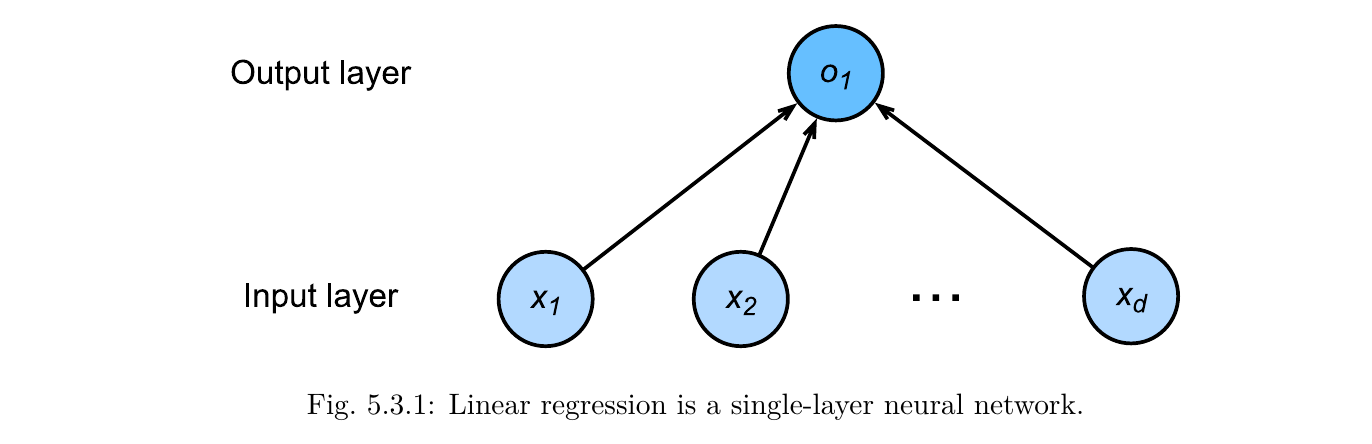

In [4]:
from IPython.display import SVG
SVG(filename="../img/singleneuron.svg")

In [5]:
class LinearRegressionModel(torch.nn.Module): 
    def __init__(self): 
        super(LinearRegressionModel, self).__init__() 
        self.layer1 = torch.nn.Linear(2, 1,bias=True)
    def forward(self, x): 
        y_pred = self.layer1(x)
        return y_pred 
    
net = LinearRegressionModel()

##  Initialize Model Parameters

Before using net, we need to initialize the model parameters, such as the weights and biases in the linear
regression model. we specify that each weight parameter should be randomly sampled from a normal distribution with mean 0 and standard deviation 0.01.
The bias parameter will be initialized to zero by default. Both weight and bias will be attached with
gradients.

In [6]:
net.layer1.weight.data=torch.Tensor(np.random.normal(size=(1,2),scale=0.01,loc=0))
net.layer1.bias.data=torch.Tensor([0])

The code above looks straightforward but in reality something quite strange is happening here. We are
initializing parameters for a network even though we haven’t yet told nn how many dimensions the input
will have. It might be 2 as in our example or it might be 2,000, so we couldn’t just preallocate enough space
to make it work.
nn let’s us get away with this because behind the scenes, the initialization is deferred until the first time
that we attempt to pass data through our network. Just be careful to remember that since the parameters
have not been initialized yet we cannot yet manipulate them in any way.

##  Define the Loss Function

In nn, there are many loss modules that defines various loss functions and we will directly use its implementation of squared loss (MSELoss).

In [7]:
loss = torch.nn.MSELoss(reduction = "sum") 

## Define the Optimization Algorithm

Not surpisingly, we aren’t the first people to implement mini-batch stochastic gradient descent, and thus
torch supports SGD alongside a number of variations on this algorithm through its Trainer class. When
we instantiate the Trainer, we’ll specify the parameters to optimize over (obtainable from our net via net.parameters()), the optimization algortihm we wish to use (sgd), and a dictionary of hyper-parameters
required by our optimization algorithm. SGD just requires that we set the value learning_rate, (here we
set it to 0.03).


In [8]:
trainer = torch.optim.SGD(net.parameters(), lr = 0.03) 

##  Training

You might have noticed that expressing our model through torch requires comparatively few lines of code.
We didn’t have to individually allocate parameters, define our loss function, or implement stochastic gradient descent. Once we start working with much more complex models, the benefits of relying on torch
abstractions will grow considerably. But once we have all the basic pieces in place, the training loop itself strikingly similar to what we did when implementing everything from scratch.
To refresh your memory: for some number of epochs, we’ll make a complete pass over the dataset
(train_data), grabbing one mini-batch of inputs and corresponding ground-truth labels at a time. 

For
each batch, we’ll go through the following ritual:

• Generate predictions by calling net(X) and calculate the loss l (the forward pass).

• Calculate gradients by calling l.backward() (the backward pass).

• Update the model parameters by invoking our SGD optimizer (note that trainer already knows which parameters to optimize over, so we just need to pass in the batch size.

For good measure, we compute the loss after each epoch and print it to monitor progress.

In [9]:
num_epochs = 3
for epoch in range(num_epochs): 
    for X,y in data_iter:
        l=loss(net(X) ,y)
        trainer.zero_grad() 
        l.backward() 
        trainer.step() 
    l_epoch = loss(net(features), labels) 
    print('epoch {}, loss {}'.format(epoch+1, l_epoch)) 

epoch 1, loss 0.10021035373210907
epoch 2, loss 0.10903461277484894
epoch 3, loss 0.11273252218961716


The model parameters we have learned and the actual model parameters are compared as below. We get
the layer we need from the net and access its weight (weight) and bias (bias). The parameters we have
learned and the actual parameters are very close.

In [10]:
w = list(net.parameters())[0][0]
print('Error in estimating w', true_w.reshape(w.shape) - w)
b = list(net.parameters())[1][0]
print('Error in estimating b', true_b - b)

Error in estimating w tensor([-0.0026,  0.0029], grad_fn=<ThSubBackward>)
Error in estimating b tensor(0.0023, grad_fn=<AddBackward>)


##  Exercises

1. If we replace l = loss(output, y) with l = loss(output, y).mean(), we need to change trainer.
step(batch_size) to trainer.step(1) accordingly. Why?
2. Review the pytorch documentation to see what loss functions and initialization methods are provided
in the modules nn.loss and init. Replace the loss by Huber’s loss.
3. How do you access the gradient of Linear.weight?
